In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from biopsykit.utils.dataframe_handling import multi_xs
import biopsykit as bp

In [3]:
import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef

from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, precision_score, recall_score, cohen_kappa_score, matthews_corrcoef
from sleep_analysis.classification.deep_learning.dl_scoring import dl_multiclass_specificity

ImportError: cannot import name 'EmradDataset' from 'empkins_io.sensors.emrad' (unknown location)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from fau_colors import register_cmaps

register_cmaps()

sns.set_theme(context="talk", style="white", palette="faculties_light", font_scale=1.2)

%matplotlib widget

In [ ]:
percent_indices = ["accuracy", "precision", "recall", "f1"]

In [ ]:
from sleep_analysis.datasets.d04_main_dataset_control import D04MainStudy

In [ ]:
classification="5stage"

In [ ]:
if classification == "5stage":
    labels = [0, 1, 2, 3, 4]
else:
    labels= [0, 1, 2]

In [ ]:
dataset = D04MainStudy(classification=classification, retrain = True)

In [ ]:
dataset = dataset.get_subset(subj_id=["18","19","22","28","34", "38","40","44"])

In [12]:
dataset

,subj_id
0,18
1,19
2,22
3,28
4,34
5,38
6,40
7,44


In [13]:
def define_stable_periods(ground_truth, predictions, window_size=2):
    # Merge data on timestamps
    data = ground_truth[["5stage"]].merge(predictions, left_index=True, right_index=True)
    
    # Define transition window in minutes
    transition_window = pd.Timedelta(minutes=window_size)
    
    data["stable"] = True  # Default to stable
    # Identify non-stable periods (if a stage change occurs within the window)
    for i in range(len(data)):
        current_time = data.index[i]
        window_start = current_time - transition_window
        window_end = current_time + transition_window
        
        nearby_stages = data.loc[(data.index >= window_start) & (data.index <= window_end), "5stage"]
        
        if nearby_stages.nunique() > 1:
            data.at[current_time, "stable"] = False
    
    # Separate stable and non-stable periods
    stable_data = data[data["stable"]]
    non_stable_data = data[~data["stable"]]
    return stable_data, non_stable_data

In [14]:
stable_data, non_stable_data = define_stable_periods(dataset[0].ground_truth, dataset[0].classification_labels)

In [15]:
def evaluate_performance(ground_truth, prediction):
    return {
        "accuracy": sk_metrics.accuracy_score(ground_truth, prediction),
        "precision": sk_metrics.precision_score(ground_truth, prediction, zero_division=0, average="weighted"),
        "recall": sk_metrics.recall_score(ground_truth, prediction, zero_division=0, average="weighted"),
        "f1": sk_metrics.f1_score(ground_truth, prediction, zero_division=0, average="weighted"),
        "kappa": sk_metrics.cohen_kappa_score(
            ground_truth,
            prediction,
        ),
        #"specificity": dl_multiclass_specificity(ground_truth, prediction, labels=labels, average="weighted"),
        "mcc": matthews_corrcoef(ground_truth, prediction),
    }

In [16]:
def analyze_transitions(ground_truth, predictions, window_size=2):
    transition_window = pd.Timedelta(minutes=window_size)
    transitions = ground_truth["5stage"].shift(1) != ground_truth["5stage"]
    transition_data = ground_truth[transitions].copy()
    transition_data["0"] = predictions.loc[transition_data.index, "0"]
    
    transition_data["prev_stage"] = transition_data["5stage"].shift(1)
    transition_data.dropna(inplace=True)
    
    # Remove invalid transitions (e.g., 0 → 0)
    transition_data = transition_data[transition_data["prev_stage"] != transition_data["5stage"]]
    
    # Convert transitions into string format with consistent integer casting
    transition_data["true_transition"] = transition_data["prev_stage"].astype(int).astype(str) + "→" + transition_data["5stage"].astype(int).astype(str)
    transition_data["pred_transition"] = transition_data["prev_stage"].astype(int).astype(str) + "→" + transition_data["0"].astype(int).astype(str)
    
    unique_transitions = sorted(set(transition_data["true_transition"]) | set(transition_data["pred_transition"]))
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        transition_data["true_transition"], transition_data["pred_transition"], labels=unique_transitions, average=None
    )
    
    transition_metrics = pd.DataFrame({
        "transition": unique_transitions,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })
    
    # Count occurrences of each transition (true and predicted)
    true_transition_counts = transition_data["true_transition"].value_counts().reset_index()
    true_transition_counts.columns = ["transition", "true_count"]
    
    pred_transition_counts = transition_data["pred_transition"].value_counts().reset_index()
    pred_transition_counts.columns = ["transition", "pred_count"]
    
    # Merge performance metrics with transition counts
    transition_metrics = transition_metrics.merge(true_transition_counts, on="transition", how="left")
    transition_metrics = transition_metrics.merge(pred_transition_counts, on="transition", how="left")
    
    return transition_metrics

In [17]:
stable_performance = {}
non_stable_performance = {}

transition_results = []

for subj in dataset:
    stable_data, non_stable_data = define_stable_periods(subj.ground_truth, subj.classification_labels)
    
    stable_performance[subj.index["subj_id"][0]]= evaluate_performance(stable_data["5stage"], stable_data["0"])
    non_stable_performance[subj.index["subj_id"][0]]= evaluate_performance(non_stable_data["5stage"], non_stable_data["0"])

    transition_metrics = analyze_transitions(subj.ground_truth, subj.classification_labels, window_size=2)
    transition_metrics["subject"] = subj.index["subj_id"][0]
    transition_results.append(transition_metrics)

In [18]:
stable_performance = pd.DataFrame(stable_performance, dtype=float)
stable_performance

,18,19,22,28,34,38,40,44
accuracy,0.692845,0.677037,0.692953,0.456000,0.777778,0.772532,0.802761,0.680412
precision,0.700425,0.669155,0.685497,0.473486,0.863761,0.836522,0.810695,0.661206
recall,0.692845,0.677037,0.692953,0.456000,0.777778,0.772532,0.802761,0.680412
f1,0.680612,0.672122,0.668566,0.416614,0.801347,0.778451,0.784399,0.656959
kappa,0.582892,0.492266,0.543308,0.197756,0.643064,0.644216,0.673405,0.507430
mcc,0.592411,0.492523,0.556983,0.214463,0.667816,0.660044,0.680892,0.521746


In [19]:
stable_performance = stable_performance.agg(["median", lambda x: x.quantile(0.75) - x.quantile(0.25)], axis=1)
stable_performance.rename(columns={'<lambda>': 'iqr'}, inplace=True)  # Rename the row for clarity
stable_performance.loc[percent_indices] *= 100
stable_performance = stable_performance.round(decimals=2).applymap("{:,.2f}".format).applymap("{:0>4}".format)
stable_performance

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_15571/4287571227.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stable_performance = stable_performance.round(decimals=2).applymap("{:,.2f}".format).applymap("{:0>4}".format)


,median,iqr
accuracy,69.29,9.43
precision,69.30,15.00
recall,69.29,9.43
f1,67.64,11.43
kappa,0.56,0.14
mcc,0.57,0.15


In [20]:
non_stable_performance = pd.DataFrame(non_stable_performance)
non_stable_performance

,18,19,22,28,34,38,40,44
accuracy,0.467213,0.444444,0.410714,0.359756,0.523297,0.472656,0.467797,0.496437
precision,0.404421,0.466327,0.377011,0.355366,0.496713,0.341239,0.514459,0.530932
recall,0.467213,0.444444,0.410714,0.359756,0.523297,0.472656,0.467797,0.496437
f1,0.412165,0.412268,0.380526,0.303253,0.507313,0.378736,0.431562,0.458796
kappa,0.296752,0.273395,0.197387,0.141992,0.325131,0.256150,0.280432,0.318718
mcc,0.310661,0.282724,0.205378,0.152791,0.328108,0.281045,0.304275,0.327023


In [21]:
non_stable_performance = non_stable_performance.agg(["median", lambda x: x.quantile(0.75) - x.quantile(0.25)], axis=1)
non_stable_performance.rename(columns={'<lambda>': 'iqr'}, inplace=True)  # Rename the row for clarity
non_stable_performance.loc[percent_indices] *= 100
non_stable_performance = non_stable_performance.round(decimals=2).applymap("{:,.2f}".format).applymap("{:0>4}".format)
non_stable_performance

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_15571/4246794246.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_stable_performance = non_stable_performance.round(decimals=2).applymap("{:,.2f}".format).applymap("{:0>4}".format)


,median,iqr
accuracy,46.75,4.26
precision,43.54,12.95
recall,46.75,4.26
f1,41.22,5.83
kappa,0.28,0.06
mcc,0.29,0.05


In [22]:
# Convert to long format
non_stable = non_stable_performance.loc[["mcc"]].T
stable = stable_performance.loc[["mcc"]].T

In [23]:
non_stable["stability"] = "transitional"
stable["stability"] = "stable"

In [24]:
df_long = pd.concat([stable, non_stable]).reset_index().melt(id_vars=["index", "stability"], 
                                                                     var_name="metric", 
                                                                     value_name="value")

# Select specific metric
df_long = df_long[df_long["metric"] == "mcc"]
df_long

,index,stability,metric,value
0,median,stable,mcc,0.57
1,iqr,stable,mcc,0.15
2,median,transitional,mcc,0.29
3,iqr,transitional,mcc,0.05


(3.15, -0.15000000000000002)


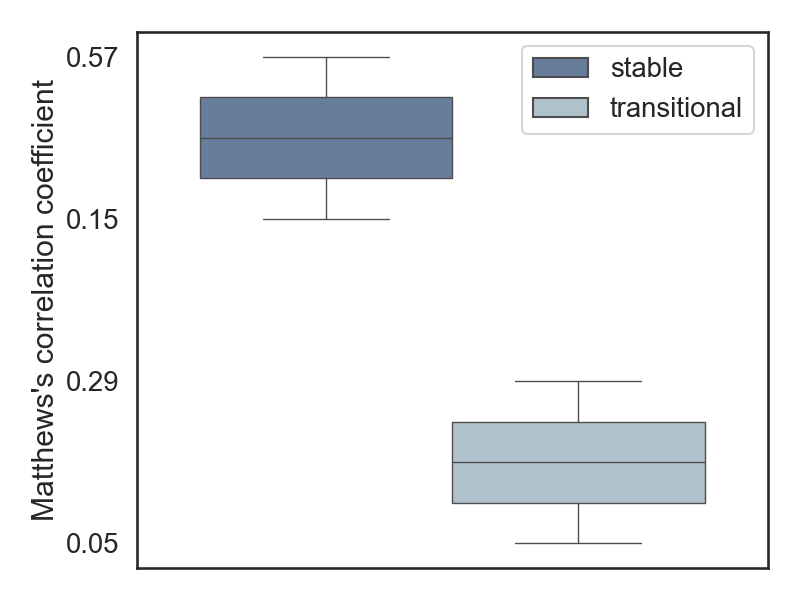

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x="metric", y="value", hue="stability", data=df_long)
ax.set_ylabel("Matthews's correlation coefficient")
ax.set_xticklabels("")
ax.set_xlabel("")
#ax.set_ylim(0,1)
print(ax.get_ylim())  # Check what Matplotlib thinks is the current y-limit

ax.legend(title="", loc="upper right")
fig.tight_layout()
plt.savefig("stability_transfer_learning.pdf", bbox_inches="tight",
)

In [26]:
pd.concat(transition_results, ignore_index=True)

,transition,precision,recall,f1_score,true_count,pred_count,subject
0,0→0,0.000000,0.000000,0.0,NaN,6.0,18
1,0→1,0.000000,0.000000,0.0,8.0,NaN,18
2,0→2,0.000000,0.000000,0.0,2.0,2.0,18
3,0→3,0.000000,0.000000,0.0,NaN,1.0,18
4,0→4,0.000000,0.000000,0.0,NaN,1.0,18
...,...,...,...,...,...,...,...
161,3→3,0.000000,0.000000,0.0,NaN,7.0,44
162,4→0,1.000000,0.333333,0.5,3.0,1.0,44
163,4→1,0.000000,0.000000,0.0,2.0,NaN,44
164,4→2,0.666667,1.000000,0.8,2.0,3.0,44


In [27]:
aggregated_transition_results = pd.concat(transition_results, ignore_index=True)
aggregated_transition_summary = aggregated_transition_results.groupby("transition").agg({
    "precision": "mean",
    "recall": "mean",
    "f1_score": "mean",
    "true_count": "sum",
    "pred_count": "sum"
}).reset_index()

In [28]:
aggregated_transition_summary

,transition,precision,recall,f1_score,true_count,pred_count
0,0→0,0.000000,0.000000,0.000000,0.0,35.0
1,0→1,0.125000,0.010417,0.019231,76.0,1.0
2,0→2,0.401637,0.613889,0.462503,27.0,44.0
3,0→3,0.041667,0.166667,0.066667,1.0,11.0
4,0→4,0.145833,0.375000,0.198214,5.0,18.0
5,1→0,0.309524,0.358333,0.301587,25.0,31.0
6,1→1,0.000000,0.000000,0.000000,0.0,1.0
7,1→2,0.848643,0.539132,0.640682,77.0,54.0
8,1→3,0.000000,0.000000,0.000000,0.0,5.0
9,1→4,0.345833,0.520833,0.337798,15.0,26.0


In [29]:
def plot_polysomnogram(ground_truth, predictions, subject_id):
    """
    Plots the polysomnogram with ground truth and predicted sleep stages.
    
    Parameters:
    - ground_truth (pd.DataFrame): DataFrame with ground truth sleep stages indexed by time.
    - predictions (pd.DataFrame): DataFrame with predicted sleep stages indexed by time.
    - subject_id (str): Identifier for the subject being plotted.
    """
    # Merge ground truth and predictions
    data = ground_truth.merge(predictions, left_index=True, right_index=True, suffixes=("_true", "_pred"))
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Plot sleep stages
    ax.plot(data.index, data['5stage'], label='Ground Truth', color='blue', alpha=0.6, linestyle='-')#, marker='o')
    ax.plot(data.index, data['0'], label='Predicted', color='red', alpha=0.6, linestyle='--')#, marker='x')
    
    # Formatting
    ax.set_ylabel("Sleep Stage")
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(["Wake", "N1", "N2", "N3", "REM"])
    ax.legend(loc='upper right')
    plt.title("Transfer Learning " + f"Polysomnogram: Sleep Stages for Subject {subject_id}")
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(subject_id + "-Transfer-Learning-Polysomnogram.pdf", bbox_inches="tight",
)

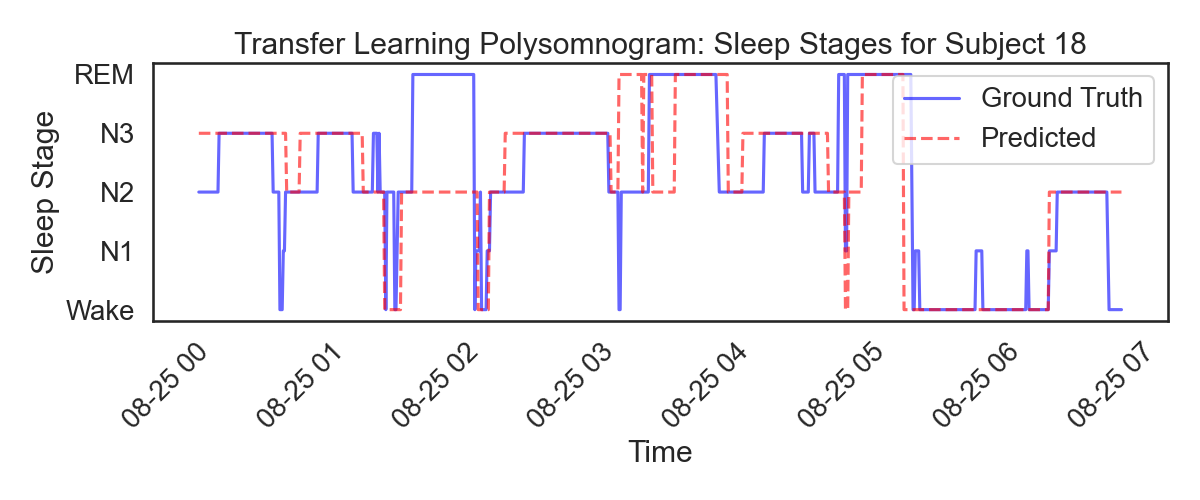

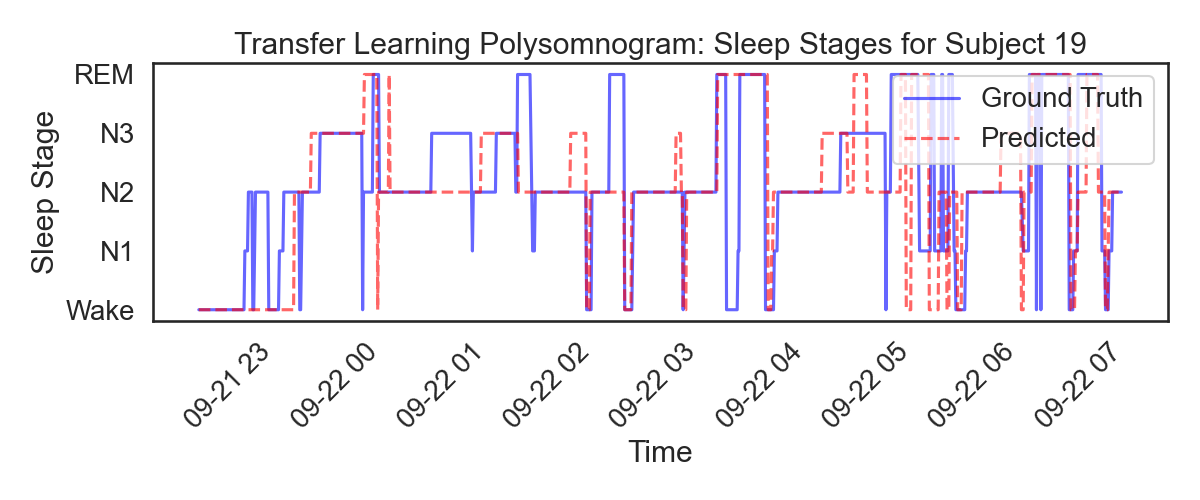

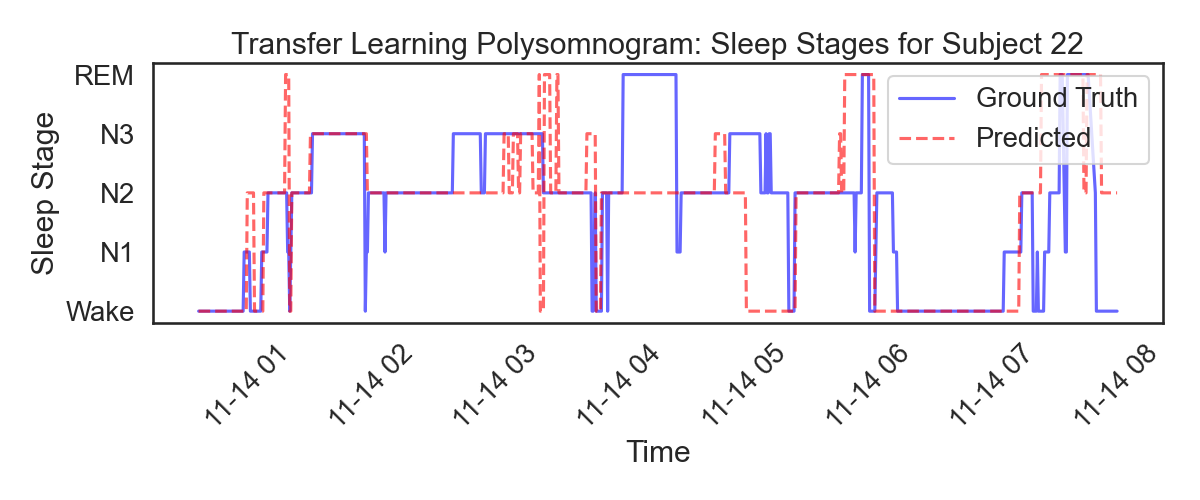

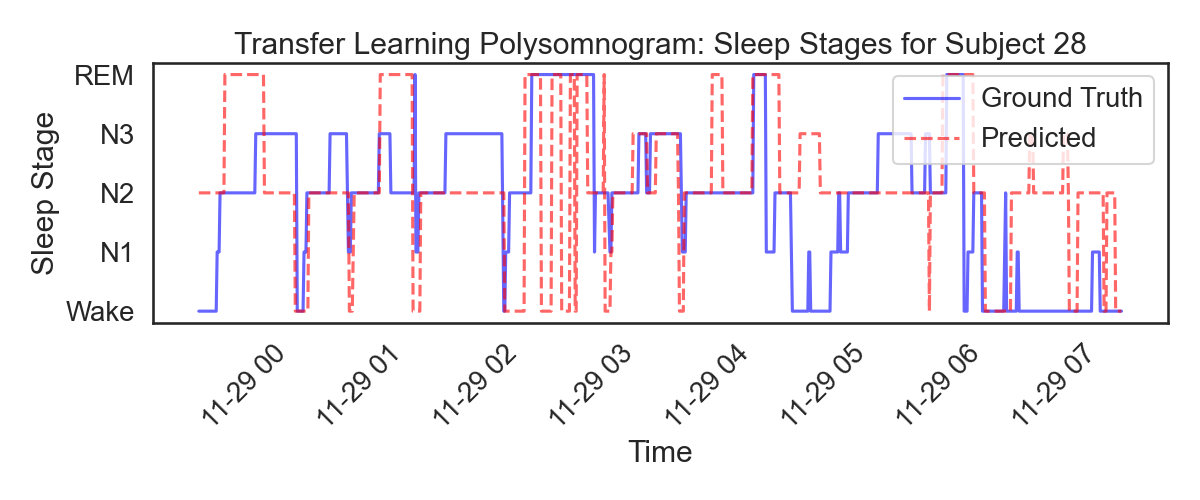

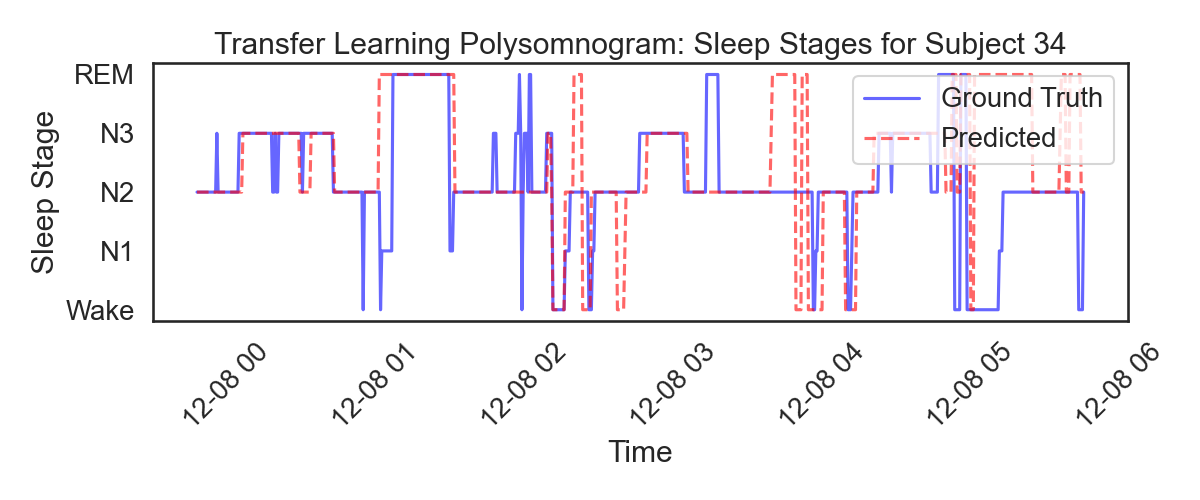

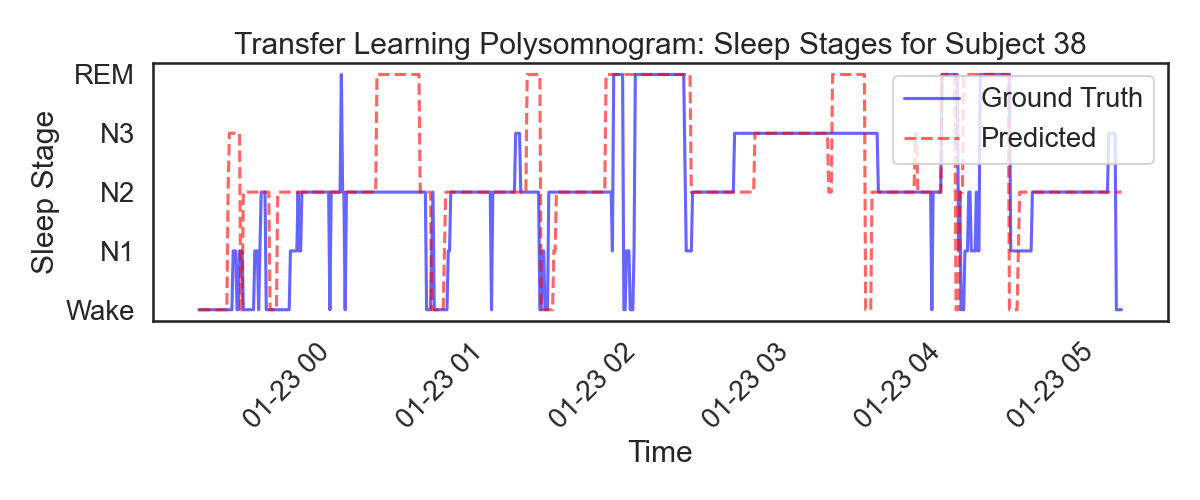

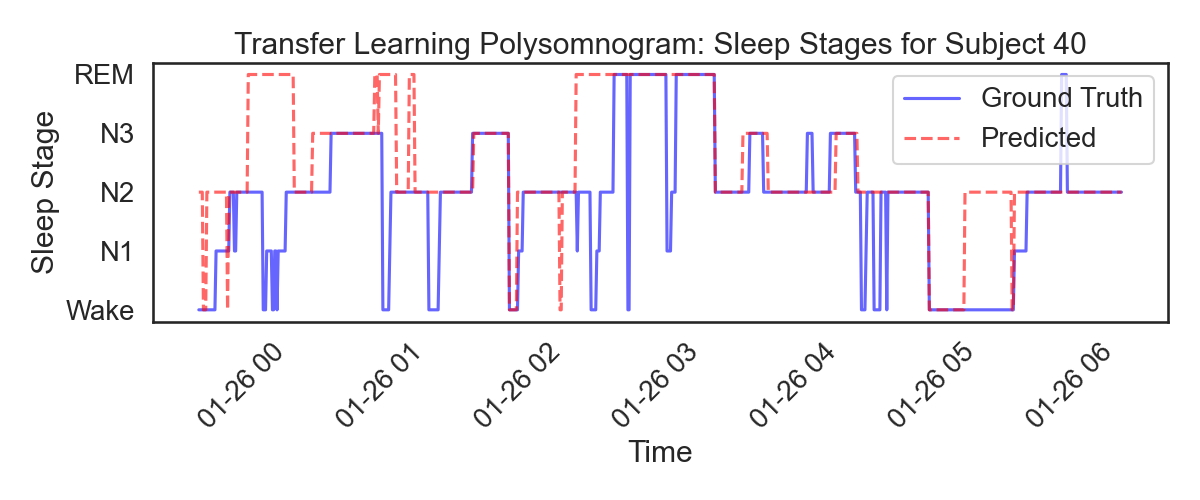

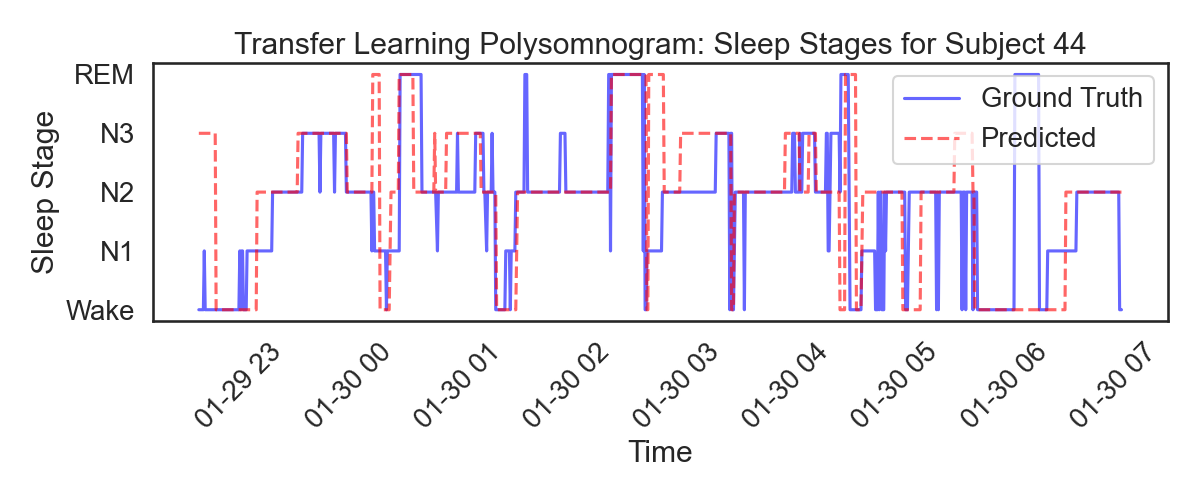

In [30]:
for subj in dataset:
    plot_polysomnogram(subj.ground_truth, subj.classification_labels, subj.index["subj_id"][0])